In [1]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece
!pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import custom module

In [4]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [5]:
from medqadataset import MedQADataset
import trainer

In [ ]:
# For debugging
# import importlib
# importlib.reload(trainer)

In [6]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_context_sum_qa_gen"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
DEVICE

'cpu'

### Read Data

In [8]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_context_sum_qa_gen.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer
0,что такое спкя?,синдром поликистозных яичников (спкя) — это со...,синдром поликистоза яичников
1,что такое синдром нунан?,"синдром нунан — это заболевание, присутствующе...","заболевание, присутствующее с рождения (врожде..."
2,что вызывает увеличение почек?,"поликистоз почек – заболевание, поражающее поч...",рост кист
3,что помогает предотвратить безглютеновая диета?,"глютен — это белок, содержащийся в пшенице, яч...",симптомы заболевания
4,что целиакия делает с ворсинками?,"целиакия – это аутоиммунное заболевание, котор...",повреждает слизистую оболочку тонкой кишки
...,...,...,...
718,что такое трансплантация поджелудочной железы?,трансплантация поджелудочной железы — это опер...,операция по пересадке здоровой поджелудочной ж...
719,что такое сирингомиелия?,"сирингомиелия — редкое заболевание, вызывающее...","редкое заболевание, которое приводит к образов..."
720,какой тип инсульта встречается реже?,геморрагический инсульт – менее распространенн...,геморрагический
721,что такое креатинин?,"креатинин — это продукт отходов, вырабатываемы...","продукт жизнедеятельности, вырабатываемый ваши..."


### Example

In [9]:
sample = data.iloc[5]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [10]:
output.loss

tensor(122.0153, grad_fn=<NllLossBackward0>)

In [ ]:
sample_q = data.iloc[5]["question"]
sample_a = data.iloc[5]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [ ]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [ ]:
" ".join(preds)

'к как ому тип у ауто им мун ного заболевани я  относ ится цели а кия ?  ауто им мун ное заболевани е '

### Dataloaders

In [11]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (566, 3)
Validation shape: (142, 3)
Test shape: (15, 3)


### Train and validation loop

In [12]:
N_EPOCHS = 100
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_context_sum_qa_gen'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [ ]:
trainer_module.fit()

Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.35it/s]


Epoch: 0		Train loss: 9.559501231556208		Validation loss: 5.057279215918647


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 1		Train loss: 5.847433288332442		Validation loss: 3.4562509059906006


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.28it/s]


Epoch: 2		Train loss: 4.340225145850383		Validation loss: 2.7398626705010733


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 3		Train loss: 3.7312238149239985		Validation loss: 2.4638277325365276


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 4		Train loss: 3.2651828838066317		Validation loss: 2.1955218050214977


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 5		Train loss: 2.9707565710578168		Validation loss: 2.0375174747573004


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 6		Train loss: 2.734722399375808		Validation loss: 1.903861893547906


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s]


Epoch: 7		Train loss: 2.6563189953145847		Validation loss: 1.8619600865576003


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Epoch: 8		Train loss: 2.2623296694856294		Validation loss: 1.6533999029133055


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 9		Train loss: 2.155698414419738		Validation loss: 1.5797932247320812


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 10		Train loss: 2.080256867576653		Validation loss: 1.4781007402473025


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 11		Train loss: 1.9588303011907657		Validation loss: 1.3587826407617993


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 12		Train loss: 1.796298730541283		Validation loss: 1.313585951924324


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s]


Epoch: 13		Train loss: 1.716262872370196		Validation loss: 1.1833221664031346


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 14		Train loss: 1.5263083044072272		Validation loss: 0.8440982732507918


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 15		Train loss: 1.2440756479619255		Validation loss: 0.7715356457564566


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 16		Train loss: 1.2268234281472756		Validation loss: 0.7479232119189368


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 17		Train loss: 1.0906349519188976		Validation loss: 0.6327497247192595


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 18		Train loss: 0.99519737925328		Validation loss: 0.5306971735424466


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 19		Train loss: 0.9282690211081169		Validation loss: 0.5198097589115301


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 20		Train loss: 0.8746849850449764		Validation loss: 0.42848406980435055


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 21		Train loss: 0.8812745120114004		Validation loss: 0.4117959940599071


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 22		Train loss: 0.77073962671656		Validation loss: 0.4083582783738772


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 23		Train loss: 0.7259622343199353		Validation loss: 0.33523690783315235


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 24		Train loss: 0.656100967610386		Validation loss: 0.2791112592029903


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s]


Epoch: 25		Train loss: 0.6323631001820027		Validation loss: 0.26338280902968514


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 26		Train loss: 0.6382189416129824		Validation loss: 0.24931122145305076


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 27		Train loss: 0.6165750234479636		Validation loss: 0.2467303847273191


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 28		Train loss: 0.5515717988912489		Validation loss: 0.19799056074892482


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 29		Train loss: 0.5147035183831		Validation loss: 0.23079977453582817


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 30		Train loss: 0.5564906124917555		Validation loss: 0.1983466280831231


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 31		Train loss: 0.5254222939027028		Validation loss: 0.17404187988075945


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 32		Train loss: 0.43621876636441326		Validation loss: 0.11321924792395698


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 33		Train loss: 0.37650663860824324		Validation loss: 0.09652995724334484


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 34		Train loss: 0.33497230204897865		Validation loss: 0.07635243011948963


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 35		Train loss: 0.3236851845408829		Validation loss: 0.06153207182392685


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 36		Train loss: 0.2792178034572534		Validation loss: 0.0614464018920747


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 37		Train loss: 0.2599968004473288		Validation loss: 0.049538292808898


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 38		Train loss: 0.22763154178228176		Validation loss: 0.04208481314385103


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.21it/s]


Epoch: 39		Train loss: 0.22290924240008625		Validation loss: 0.04117797574468164


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Epoch: 40		Train loss: 0.20874540120835455		Validation loss: 0.025942982122715976


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 41		Train loss: 0.18830441284767338		Validation loss: 0.021825533353775326


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s]


Epoch: 42		Train loss: 0.1553165447360403		Validation loss: 0.018342350657298487


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 43		Train loss: 0.16344704799039264		Validation loss: 0.021063900471846055


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 44		Train loss: 0.1702557472695767		Validation loss: 0.015660826257468823


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 45		Train loss: 0.22230452977278284		Validation loss: 0.02507698406487988


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s]


Epoch: 46		Train loss: 0.1424282656779224		Validation loss: 0.0111746016870408


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 47		Train loss: 0.11106760317826984		Validation loss: 0.009800406623576742


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 48		Train loss: 0.1193729366215182		Validation loss: 0.0055119055454674205


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 49		Train loss: 0.11179536260323415		Validation loss: 0.0037797736125260903


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 50		Train loss: 0.0954320835093902		Validation loss: 0.004733191797236537


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 51		Train loss: 0.09588479587454087		Validation loss: 0.004248524661003709


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 52		Train loss: 0.08757143483241417		Validation loss: 0.0045021908738110345


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 53		Train loss: 0.09078729920692637		Validation loss: 0.005734911360984067


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 54		Train loss: 0.06979274389032326		Validation loss: 0.003341134240852423


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 55		Train loss: 0.06560120914577389		Validation loss: 0.001678257770991978


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Epoch: 56		Train loss: 0.059226395916456065		Validation loss: 0.002848018878921721


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 57		Train loss: 0.060379799071725616		Validation loss: 0.0012816323266835955


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 58		Train loss: 0.05711248312407816		Validation loss: 0.0011113441647568026


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 59		Train loss: 0.06008558541669143		Validation loss: 0.0019775827360919923


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 60		Train loss: 0.05116423376849		Validation loss: 0.002488581193852547


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.21it/s]


Epoch: 61		Train loss: 0.052015161182744504		Validation loss: 0.0011247660665705756


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 62		Train loss: 0.043540975356451565		Validation loss: 0.0013414409719037697


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 63		Train loss: 0.03974070963794103		Validation loss: 0.0008280616103301478


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 64		Train loss: 0.048755130935116		Validation loss: 0.000910097589326142


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 65		Train loss: 0.49852311147194894		Validation loss: 0.5699588300453292


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 66		Train loss: 0.2870723783156612		Validation loss: 0.07109806165519533


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 67		Train loss: 0.13949440801385002		Validation loss: 0.01923287123524157


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 68		Train loss: 0.09656577177581863		Validation loss: 0.007634947339182772


Training batches: 100%|██████████| 142/142 [01:39<00:00,  1.43it/s]


Epoch 00070: reducing learning rate of group 0 to 1.0000e-05.


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 69		Train loss: 0.07536936761535915		Validation loss: 0.0015453965177382794


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 70		Train loss: 0.05211556643332866		Validation loss: 0.001030902263361592


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 71		Train loss: 0.03683715084039698		Validation loss: 0.000856778734462043


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 72		Train loss: 0.04269255389882461		Validation loss: 0.0007501478694393882


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 73		Train loss: 0.0409096059287754		Validation loss: 0.0007319917196784647


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


Epoch: 74		Train loss: 0.041683365502739066		Validation loss: 0.0006687207135200879


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 75		Train loss: 0.03973958804210628		Validation loss: 0.0005401301958474707


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 76		Train loss: 0.035789868299206586		Validation loss: 0.0004447988524387054


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Epoch: 77		Train loss: 0.03982932289978686		Validation loss: 0.0003499708290948749


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 78		Train loss: 0.026059329203120103		Validation loss: 0.0004378322426153621


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 79		Train loss: 0.04786175730659521		Validation loss: 0.0003974141169907044


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 80		Train loss: 0.031590579544082543		Validation loss: 0.00033458660497368936


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 81		Train loss: 0.02427413269777415		Validation loss: 0.0005233221981168552


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 82		Train loss: 0.02853519433775661		Validation loss: 0.0002752567903977858


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 83		Train loss: 0.029326623234558445		Validation loss: 0.0003211444226280946


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 84		Train loss: 0.029701043059926442		Validation loss: 0.0003493988314744456


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 85		Train loss: 0.02345795501810564		Validation loss: 0.000531180326561298


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 86		Train loss: 0.02277933036466621		Validation loss: 0.00034770921314475345


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 87		Train loss: 0.024667649508968756		Validation loss: 0.0001692018467325498


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Epoch: 88		Train loss: 0.019822286783994673		Validation loss: 0.00014359162252554193


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 89		Train loss: 0.024231608580752		Validation loss: 0.00012149143837329272


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.23it/s]


Epoch: 90		Train loss: 0.01911406714344581		Validation loss: 7.791856603726426e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.26it/s]


Epoch: 91		Train loss: 0.019990541874455668		Validation loss: 7.628337934622525e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 92		Train loss: 0.019687584572238848		Validation loss: 7.8086828595916e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 93		Train loss: 0.017812993935133907		Validation loss: 8.09368267545728e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 94		Train loss: 0.017380600189298233		Validation loss: 9.323485582197261e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.27it/s]


Epoch: 95		Train loss: 0.019247936192263757		Validation loss: 7.074219107355223e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.25it/s]


Epoch: 96		Train loss: 0.02215400430895257		Validation loss: 0.0001000991168022362


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 97		Train loss: 0.014167892229829384		Validation loss: 8.088732023183966e-05


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.24it/s]


Epoch: 98		Train loss: 0.014976801994635025		Validation loss: 0.00014568037621466424


Validation batches: 100%|██████████| 36/36 [00:08<00:00,  4.28it/s]

Epoch: 99		Train loss: 0.023550756819403572		Validation loss: 0.00020198024195552635


### Evaluate results

In [14]:
test_sample = test_data.iloc[0]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"Ответ: {test_sample['answer']}"

test_question

pred = trainer_module.predict_answer(
    test_context,
    test_question,
    test_answer,
    print_text=True
)

pred

Контекст: прогрессирующая семейная блокада сердца — это генетическое заболевание, которое нарушает нормальное биение сердца. это происходит, когда электрическая передача сигналов затруднена где-либо от предсердий до желудочков. в соединенных штатах примерно у 1 из 5000 человек наблюдается полная блокада сердца по любой причине.
Вопрос:  что такое прогрессирующая семейная блокада сердца?
Ответ: генетическое заболевание, которое изменяет нормальное биение сердца


{'Reference Answer: ': 'Ответ: генетическое заболевание, которое изменяет нормальное биение сердца',
 'Predicted Answer: ': 'Ответ: генетическое заболевание, которое изменяет нормальное биение сердца',
 'BLEU Score: ': {'google_bleu': 1.0},
 'RougeL (precision): ': 1.0}

In [15]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.8783993783993783
RougeL: 0.8825396825396825


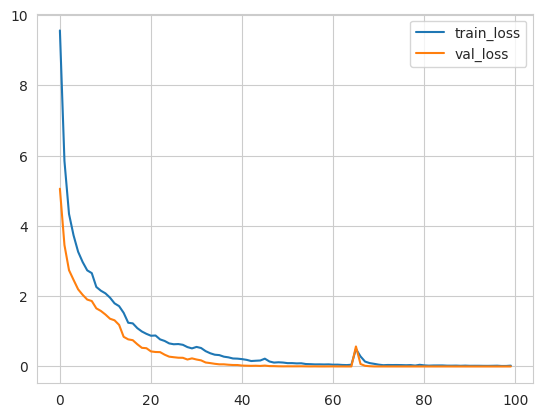

In [ ]:
trainer_module.plot_loss()

### Inference

In [17]:
test_sample = test_data.iloc[1]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что делает токсикологический скрининг?
Контекст: токсикологический анализ может определить тип и приблизительное количество разрешенных и незаконных наркотиков. чаще всего это делается с использованием образца крови или мочи. это можно сделать вскоре после того, как человек проглотил лекарство или после рвоты.
Ответ: определить вид и примерное количество легальных и нелегальных наркотиков


In [19]:
test_sample = test_data.iloc[2]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое антидепрессанты?
Контекст: антидепрессанты — это отпускаемые по рецепту лекарства, которые вы можете принимать, чтобы помочь при депрессии, тревоге или боли. если вы внезапно прекратите принимать лекарство, вы рискуете: возвращение симптомов, таких как тяжелая депрессия.
Ответ: рецептурные лекарства, которые вы можете принимать, чтобы помочь при депрессии, тревоге или боли


In [21]:
test_sample = test_data.iloc[5]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что означает дхеа?
Контекст: деа означает дегидроэпиандростерон, гормон, вырабатываемый надпочечниками как у мужчин, так и у женщин. он может конвертироваться в другие гормоны, обладающие слабым мужским (андрогенным) действием.
Ответ: дегидроэпиандростерон


In [27]:
test_context = f"Контекст: Холецистит является воспалительным процессом, который возникает в желчном пузыре. От этой патологии сегодня страдает около 20% жителей всего мира. Причем наиболее подвержены заболеванию женщины старше 50 лет. Воспаление выявляют у людей и другого возраста. Причем для детей и подростков характерна бескаменная форма. Зачастую болезнь диагностируется в развитых странах. Обусловлено это особым образом жизни и пищевым поведением."
test_question = f"Вопрос: Нужно ли обращаться к врачу, если есть признаки холецистита?"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: Нужно ли обращаться к врачу, если есть признаки холецистита?
Контекст: Холецистит является воспалительным процессом, который возникает в желчном пузыре. От этой патологии сегодня страдает около 20% жителей всего мира. Причем наиболее подвержены заболеванию женщины старше 50 лет. Воспаление выявляют у людей и другого возраста. Причем для детей и подростков характерна бескаменная форма. Зачастую болезнь диагностируется в развитых странах. Обусловлено это особым образом жизни и пищевым поведением.
Ответ: воспаление возникает в желчном пузыре
